In [803]:
import matplotlib
#import matplotlib.pyplot as plt
import os
import json
import pickle
import numpy as np
from pathlib import Path
from enum import Enum
import scipy.constants as sc
from scipy.signal import savgol_filter
#from tensorboard.backend.event_processing.event_file_loader import EventFileLoader

plt = matplotlib.pyplot

In [804]:
class Tag(Enum):
    CUMULATIVE_REWARD = "cumulative_rewards"
    EP_LENGTH = "ep_length"
    DOOR_PASSAGE = "passage"
    COLLISION_INITIAL = "initial"
    COLLISION_STAY = "stay"
    COLLISION_TOTAL = "total"

class Plot(Enum):
    COLLISION = 0
    ENV1 = 2
    LINEPLOT = 1

tag_colors = {
    Tag.CUMULATIVE_REWARD: "C1",
    Tag.EP_LENGTH: "C2"
    }

Select from what run to get data. Also choose the Type of data.

In [805]:
multiple_runs = True
selected_runs: list[int] = [6459] #list(range(6445, 6454))
#selected_run = 1000
plot_step = 5
plot_all = True
selected_tag = Tag.EP_LENGTH
selected_plot = Plot.ENV1

In [806]:
def get_y_data(summary_dict: dict, id: int, tag: Tag):
    if tag in [Tag.CUMULATIVE_REWARD, Tag.EP_LENGTH]:
        return summary_dict[id]["env"][tag.value]
    if tag is Tag.DOOR_PASSAGE:
        return summary_dict[id]["door"][tag.value]
    if tag in [Tag.COLLISION_STAY, Tag.COLLISION_INITIAL, Tag.COLLISION_STAY]:
        return summary_dict[id]["collision"][tag.value]

In [807]:
def get_x_data(summary_dict: dict, id: int, tag: Tag):
    d = len(get_y_data(summary_dict, id, tag))
    return summary_dict[id]["steps"][:d]

In [808]:
def filter_data(data):
    return savgol_filter(data, 15, 2)

In [809]:
# Load the pickle with all the run data.
summary_file_path = Path("C:/Users/max.muehlefeldt/Documents/GitHub/unity-machine-learning/python/basic_rl_env/summary_dict.pickle").absolute()

with open(summary_file_path, mode="rb") as file:
    summary_dict = pickle.load(file)

In [810]:
# Global plot settings
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams["font.family"] = 'serif'

In [811]:
if selected_plot is Plot.LINEPLOT:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)

    # First plot.
    #selected_tag = Tag.EP_LENGTH
    axs_first = fig.add_subplot(gs[0, 0])
    #fig.suptitle(f"Runs {selected_runs[0]} - {selected_runs[-1]}", y=0.95)
    #fig.tight_layout()

    for id in selected_runs:
        #sensor_count = content[id]['stats']['sensorCount']
        sensor_count = summary_dict[id]["file_contents"]["unity_config"]["sensorCount"]
        #print(sensor_count)
        #run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors, run {id}"
        run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors"
        #run_label += f", no LSTM" if id == 6108 else ", with LSTM"

        #x = content[id]["x_values"][selected_tag]
        x = get_x_data(summary_dict, id, selected_tag)
        #y = savgol_filter( content[id]["y_values"][selected_tag], 15, 2)
        y = savgol_filter( get_y_data(summary_dict, id, selected_tag), 15, 2)
        #x = content[id]["x_values"][selected_tag]
        axs_first.plot(
            x, 
            y,
            #color=tag_colors[selected_tag]
            label=run_label
            )
    
    
    if selected_tag is Tag.CUMULATIVE_REWARD:
        #axs_first.set_ylim(-2, 1.5)
        axs_first.set_ylim(-2, 1.1)
        #axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
        axs_first.axhline(1.0, label="Reward limit = 1.0", color="C3", linestyle="dashed")
        axs_first.set_ylabel("Reward")
        axs_first.set_title("Cumulative reward")

    elif selected_tag is Tag.EP_LENGTH:
        axs_first.set_ylim(0, 200)
        axs_first.set_ylabel("Length")
        axs_first.set_title("Episode length")
    
    elif selected_tag is Tag.DOOR_PASSAGE:
        axs_first.set_ylim(-1, 1)
        axs_first.set_ylabel("Passage Quality")
        axs_first.set_title("Door passage")
    
    axs_first.set_xlabel("Step")
    
    axs_first.legend()
    axs_first.grid()   

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_tag}.pdf")

In [812]:
summary_dict.keys()
#len(get_y_data(summary_dict, id, Tag.COLLISION_INITIAL))
#len(get_y_data(summary_dict, id, Tag.COLLISION_STAY))
#len(summary_dict[id]["steps"])

dict_keys([6450, 6451, 6452, 6453, 6454, 6455, 6456, 6457, 6458, 6459])

In [813]:
if selected_plot is Plot.COLLISION:
    fig = plt.figure(figsize=(9, 7))
    fig.patch.set_alpha(0.)
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)
    axs_first = fig.add_subplot(gs[0, 0])

    for id in selected_runs:
        #sensor_count = content[id]['stats']['sensorCount']
        sensor_count = summary_dict[id]["file_contents"]["unity_config"]["sensorCount"]
        #print(sensor_count)
        #run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors, run {id}"
        run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors"
        #run_label += f", no LSTM" if id == 6108 else ", with LSTM"

        #x = content[id]["x_values"][selected_tag]
        x = get_x_data(summary_dict, id, selected_tag)
        #y = savgol_filter( content[id]["y_values"][selected_tag], 15, 2)
        #y = savgol_filter( get_y_data(summary_dict, id, selected_tag), 15, 2)
        #x = content[id]["x_values"][selected_tag]
        #axs_first.plot(
        #    x, 
        #    y,
        #    #color=tag_colors[selected_tag]
        #    label=run_label
        #    )

        
        y_initial = filter_data(get_y_data(summary_dict, id, Tag.COLLISION_INITIAL))
        y_stay = filter_data(get_y_data(summary_dict, id, Tag.COLLISION_STAY))

        if len(y_initial) != len(y_stay):
            if len(y_initial) < len(y_stay):
                d = len(y_initial)
                y_stay = y_stay[:d]
                x = x[:d]
            else:
                d = len(y_stay)
                y_initial = y_initial[:d]
                x = x[:d]
        
        y = np.vstack([y_initial, y_stay])

        

        axs_first.stackplot(
            x, y,
            labels=["Initial contact", "Continued contact"],
            alpha=0.8
        )

        axs_first.set_ylim(0, 200)
    #if selected_tag is Tag.CUMULATIVE_REWARD:
    #    #axs_first.set_ylim(-2, 1.5)
    #    axs_first.set_ylim(-2, 1.1)
        #axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
    #    axs_first.axhline(1.0, label="Reward limit = 1.0", color="C3", linestyle="dashed")
        axs_first.set_ylabel("Count")
        axs_first.set_title("Collisions")

    #elif selected_tag is Tag.EP_LENGTH:
    #    axs_first.set_ylim(0, 200)
    #    axs_first.set_ylabel("Length")
    #    axs_first.set_title("Episode length")
    
    #elif selected_tag is Tag.DOOR_PASSAGE:
    #    axs_first.set_ylim(-1, 1)
    #    axs_first.set_ylabel("Passage Quality")
    #    axs_first.set_title("Door passage")
    
        axs_first.set_xlabel("Step")
        
        axs_first.legend()
        axs_first.grid()   

        plt.subplots_adjust(hspace=0.4)
        plt.style.use("default")
        plt.tight_layout()
        #plt.savefig(f"{selected_run}_all.pdf")
        fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")

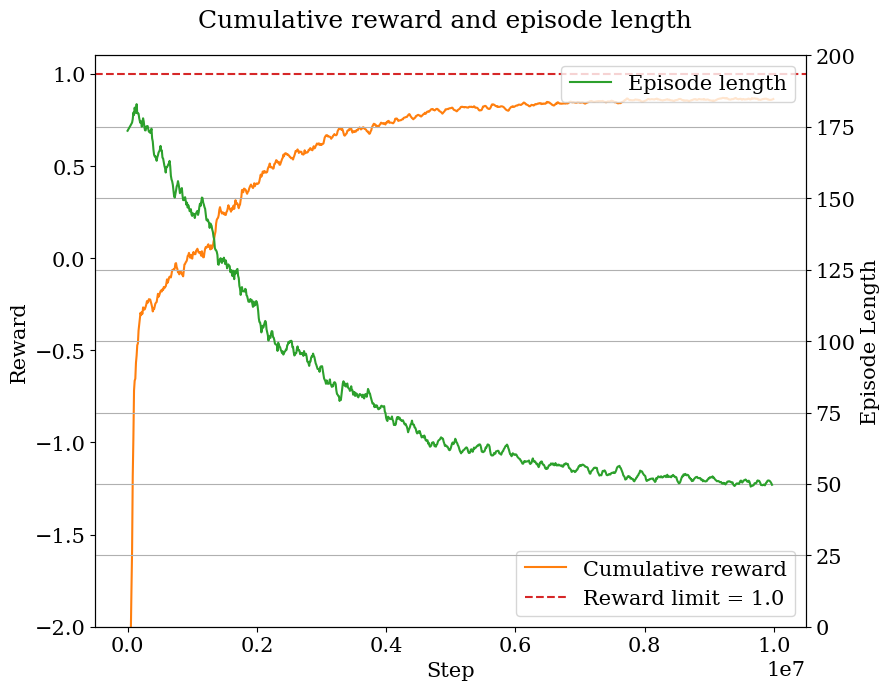

In [814]:
if selected_plot is Plot.ENV1:
    fig = plt.figure(figsize=(9, 7))
    #fig = plt.figure()
    fig.patch.set_alpha(0.)
    
    gs = fig.add_gridspec(ncols=1, nrows=1, figure=fig)

    # First plot.
    #selected_tag = Tag.EP_LENGTH
    axs_first = fig.add_subplot(gs[0, 0])
    #fig.suptitle(f"Runs {selected_runs[0]} - {selected_runs[-1]}", y=0.95)
    #fig.tight_layout()

    for id in selected_runs:
        #sensor_count = content[id]['stats']['sensorCount']
        sensor_count = summary_dict[id]["file_contents"]["unity_config"]["sensorCount"]
        #print(sensor_count)
        #run_label = f"{sensor_count} sensor" if sensor_count == 1 else f"{sensor_count} sensors, run {id}"

        run_label = f"Cumulutive reward"
        selected_tag = Tag.CUMULATIVE_REWARD
        #x = content[id]["x_values"][selected_tag]
        x = get_x_data(summary_dict, id, selected_tag)
        #y = savgol_filter( content[id]["y_values"][selected_tag], 15, 2)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
        #x = content[id]["x_values"][selected_tag]
        axs_first.plot(
            x, 
            y,
            color=tag_colors[selected_tag],
            label="Cumulative reward",
            )
        axs_first.set_ylim(-2, 1.1)
        axs_first.set_ylabel("Reward")
        axs_first.axhline(1.0, label="Reward limit = 1.0", color="C3", linestyle="dashed")

        selected_tag = Tag.EP_LENGTH
        x = get_x_data(summary_dict, id, selected_tag)
        y = filter_data(get_y_data(summary_dict, id, selected_tag))
        axs_second = axs_first.twinx()
        axs_second.plot(
            x, 
            y,
            color=tag_colors[selected_tag],
            label="Episode length",
            )
        axs_second.set_ylim(0, 200)
        axs_second.set_ylabel("Episode Length")
        fig.suptitle("Cumulative reward and episode length")
    
    """if selected_tag is Tag.CUMULATIVE_REWARD:
        #axs_first.set_ylim(-2, 1.5)
        axs_first.set_ylim(-2, 1.1)
        #axs_first.axhline(1.25, label="Reward limit = 1.25", color="C3", linestyle="dashed")
        axs_first.axhline(1.0, label="Reward limit = 1.0", color="C3", linestyle="dashed")
        axs_first.set_ylabel("Reward")
        axs_first.set_title("Cumulative reward")

    elif selected_tag is Tag.EP_LENGTH:
        axs_first.set_ylim(0, 200)
        axs_first.set_ylabel("Length")
        axs_first.set_title("Episode length")"""
    
    axs_first.set_xlabel("Step")
    
    axs_second.legend()
    axs_first.legend()
    axs_second.grid()
    #axs_first.grid()

    plt.subplots_adjust(hspace=0.4)
    plt.style.use("default")
    plt.tight_layout()
    #plt.savefig(f"{selected_run}_all.pdf")
    fig.savefig(f"{selected_runs[0]}-{selected_runs[-1]}_{selected_plot}.pdf")